### Intoduction to image segmentation in opencv in python  - 2022 0114 CJH
---
* if you don't have it, get it with `pip install opencv-python`

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import glob

### open image in correct color space and displaying with matplotlib

In [2]:
files = glob.glob('**/*.png*', recursive=True)
files

['colors.png',
 'yellow_balls.png',
 'shooter\\shooter_training.png',
 'shooter\\shooter_training_fartheraway.png',
 'shooter\\shooter_training_fartheraway_rotated.png',
 'shooter\\shooter_training_too_bright.png']

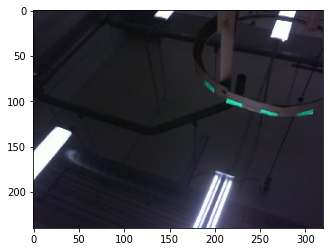

In [25]:
img_rgb = cv2.cvtColor(cv2.imread(files[4]), cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)   # Ploting the image using matplotlib

### blur - helps to remove noise

In [26]:
from enum import Enum
BlurType = Enum('BlurType', 'Box_Blur Gaussian_Blur Median_Filter Bilateral_Filter')
def blur(src, type, radius):
    """Softens an image using one of several filters.
    Args:
        src: The source mat (numpy.ndarray).
        type: The blurType to perform represented as an int.
        radius: The radius for the blur as a float.
    Returns:
        A numpy.ndarray that has been blurred.
    """
    if(type is BlurType.Box_Blur):
        ksize = int(2 * round(radius) + 1)
        return cv2.blur(src, (ksize, ksize))
    elif(type is BlurType.Gaussian_Blur):
        ksize = int(6 * round(radius) + 1)
        return cv2.GaussianBlur(src, (ksize, ksize), round(radius))
    elif(type is BlurType.Median_Filter):
        ksize = int(2 * round(radius) + 1)
        return cv2.medianBlur(src, ksize)
    else:
        return cv2.bilateralFilter(src, -1, round(radius), round(radius))

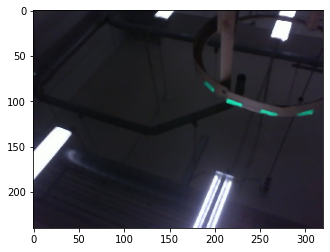

In [27]:
#blurred_image = img_rgb.copy()
blurred_image = blur(img_rgb.copy(), BlurType.Median_Filter, 1.0)
plt.imshow(blurred_image)

### hsv threshold - pick out colors

In [28]:
def hsv_threshold(input, hue, sat, val):
    """Segment an image based on hue, saturation, and value ranges.
    Args:
        input: A BGR numpy.ndarray.
        hue: A list of two numbers the are the min and max hue.
        sat: A list of two numbers the are the min and max saturation.
        lum: A list of two numbers the are the min and max value.
    Returns:
        A black and white numpy.ndarray.
    """
    out = cv2.cvtColor(input, cv2.COLOR_RGB2HSV)
    return cv2.inRange(out, (hue[0], sat[0], val[0]),  (hue[1], sat[1], val[1]))

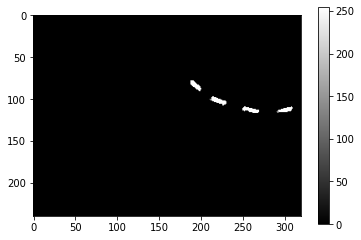

In [29]:
h = [76, 90]
s = [100, 255]
v = [40, 255]
hsv_thresh_image = hsv_threshold(blurred_image, h, s, v)
plt.imshow(hsv_thresh_image, cmap='gray')
plt.colorbar()

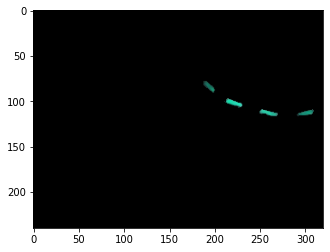

In [30]:
plt.imshow(blurred_image*(hsv_thresh_image//255)[:,:,np.newaxis])

### find contours

In [31]:
def find_contours(input, external_only):
    """Sets the values of pixels in a binary image to their distance to the nearest black pixel.
    Args:
        input: A numpy.ndarray.
        external_only: A boolean. If true only external contours are found.
    Return:
        A list of numpy.ndarray where each one represents a contour.
    """
    if(external_only):
        mode = cv2.RETR_EXTERNAL
    else:
        mode = cv2.RETR_LIST
    method = cv2.CHAIN_APPROX_SIMPLE
    contours, hierarchy =cv2.findContours(input, mode=mode, method=method)
    return contours

In [32]:
contours = find_contours(hsv_thresh_image, True)
len(contours)

4

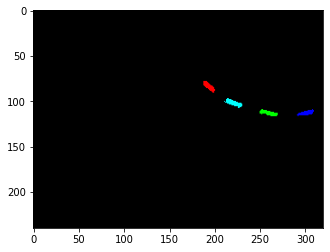

In [33]:
black = np.zeros_like(img_rgb)
for ix, contour in enumerate(contours):
    color = (([255*int(i) for i in f'{(ix+1) % 8:03b}']))
    cv2.drawContours(black , contours, ix, color, -1)
plt.imshow(black)

In [34]:
def filter_contours(input_contours, min_area, min_perimeter, min_width, max_width,
                    min_height, max_height, solidity, max_vertex_count, min_vertex_count,
                    min_ratio, max_ratio):
    """Filters out contours that do not meet certain criteria.
    Args:
        input_contours: Contours as a list of numpy.ndarray.
        min_area: The minimum area of a contour that will be kept.
        min_perimeter: The minimum perimeter of a contour that will be kept.
        min_width: Minimum width of a contour.
        max_width: MaxWidth maximum width.
        min_height: Minimum height.
        max_height: Maximimum height.
        solidity: The minimum and maximum solidity of a contour.
        min_vertex_count: Minimum vertex Count of the contours.
        max_vertex_count: Maximum vertex Count.
        min_ratio: Minimum ratio of width to height.
        max_ratio: Maximum ratio of width to height.
    Returns:
        Contours as a list of numpy.ndarray.
    """
    output = []
    for contour in input_contours:
        x,y,w,h = cv2.boundingRect(contour)
        if (w < min_width or w > max_width):
            continue
        if (h < min_height or h > max_height):
            continue
        area = cv2.contourArea(contour)
        if (area < min_area):
            continue
        if (cv2.arcLength(contour, True) < min_perimeter):
            continue
        hull = cv2.convexHull(contour)
        solid = 100 * area / cv2.contourArea(hull)
        if (solid < solidity[0] or solid > solidity[1]):
            continue
        if (len(contour) < min_vertex_count or len(contour) > max_vertex_count):
            continue
        ratio = (float)(w) / h
        if (ratio < min_ratio or ratio > max_ratio):
            continue
        output.append(contour)
    return output

In [35]:
min_area = 5.0
min_perimeter = 0.0
min_width = 3.0
max_width = 100
min_height = 3.0
max_height = 1000
solidity = [20, 100.0]
max_vertices = 1000000
min_vertices = 0
min_ratio = 0.5
max_ratio = 6
filtered_contours = filter_contours(contours, min_area, min_perimeter, min_width, max_width,
                    min_height, max_height, solidity, max_vertices, min_vertices,
                    min_ratio, max_ratio)

len(filtered_contours)

4

In [36]:
def overlay_bounding_boxes(image, contours):
    """Draw a box around all of our contours with the main one emphasized"""
    for ix, contour in enumerate(contours):
        color = ([255*int(i) for i in f'{(ix+1) % 7:03b}'])
        rect = cv2.boundingRect(contour)
        thickness = 2
        #print(rect)
        image = cv2.rectangle(image, (int(rect[0]), int(rect[1])), (int(rect[0] + rect[2]), int(rect[1] + rect[3])), color, thickness)
    return image

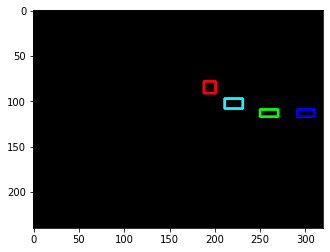

In [37]:
black = np.zeros_like(img_rgb)
contour_image = overlay_bounding_boxes(black, contours)
plt.imshow(contour_image)

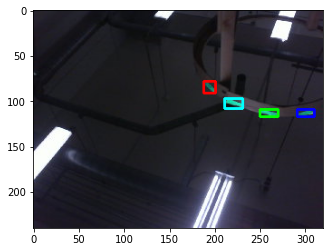

In [38]:
boxed_image = overlay_bounding_boxes(img_rgb.copy(), contours)
plt.imshow(boxed_image)

In [39]:
def overlay_text(image, contours):
    """Draw a box around all of our contours with the main one emphasized"""
    for ix, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        image = cv2.putText(image, str(ix), (int(x+0.4*w), int(y+0.6*h)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,255,0), 1);
    return image

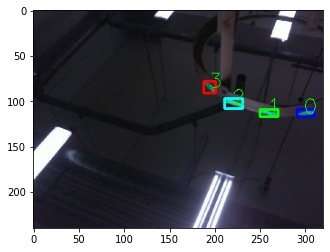

In [40]:
labeled_image = overlay_text(boxed_image.copy(), contours)
plt.imshow(labeled_image)

In [41]:
filtered_contours

[array([[[308, 109]],
 
        [[307, 110]],
 
        [[303, 110]],
 
        [[302, 111]],
 
        [[299, 111]],
 
        [[298, 112]],
 
        [[296, 112]],
 
        [[295, 113]],
 
        [[293, 113]],
 
        [[291, 115]],
 
        [[292, 116]],
 
        [[293, 115]],
 
        [[303, 115]],
 
        [[304, 114]],
 
        [[307, 114]],
 
        [[308, 113]],
 
        [[308, 112]],
 
        [[309, 111]],
 
        [[309, 110]]], dtype=int32),
 array([[[252, 109]],
 
        [[250, 111]],
 
        [[250, 113]],
 
        [[251, 113]],
 
        [[252, 114]],
 
        [[253, 113]],
 
        [[256, 113]],
 
        [[258, 115]],
 
        [[261, 115]],
 
        [[262, 116]],
 
        [[268, 116]],
 
        [[269, 115]],
 
        [[269, 113]],
 
        [[266, 113]],
 
        [[265, 112]],
 
        [[262, 112]],
 
        [[261, 111]],
 
        [[258, 111]],
 
        [[257, 110]],
 
        [[254, 110]],
 
        [[253, 109]]], dtype=int32),
 array([[[214,

#### let's find the average box location and target extents 

In [42]:
def find_centers(contours):
    if len(contours) > 0:
        x_centers = []
        y_centers = []
        left_boundary = 1000
        right_boundary = 0
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            print(y,y,w,h)
            x_centers.append(x + w//2)
            y_centers.append(y + h//2)
            left_boundary = x if x < left_boundary else left_boundary
            right_boundary = x+w if x+w > right_boundary else right_boundary
            hub_x, hub_y = int(np.mean(x_centers)), int(np.mean(y_centers)),
        return  hub_x, hub_y, left_boundary, right_boundary
    else:
        return 0, 0, 0 , 0

hub_x, hub_y, left_boundary, right_boundary = find_centers(contours) 
hub_x, hub_y, left_boundary, right_boundary

109 109 19 8
109 109 20 8
97 97 20 11
78 78 13 13


(243, 103, 188, 310)

---
### putting it all together

In [43]:
def process(image):
    im = image.copy()
    blurred_image = blur(im, BlurType.Median_Filter, 1)
    hsv_thresh_image = hsv_threshold(blurred_image, h, s, v)
    contours = find_contours(hsv_thresh_image, True)
    filtered_contours = filter_contours(contours, min_area, min_perimeter, min_width, max_width,
                    min_height, max_height, solidity, max_vertices, min_vertices,
                    min_ratio, max_ratio)
    boxed_image = overlay_bounding_boxes(img_rgb.copy(), filtered_contours)
    
    hub_x, hub_y, left_boundary, right_boundary = find_centers(filtered_contours) 
    im_height, im_width, _ = img_rgb.shape
    cv2.line(boxed_image, (hub_x, 20), (hub_x, im_height - 20), (255, 127, 0), 2)   # Draw the line: image, start, stop, color, thickness
    cv2.line(boxed_image, (left_boundary, hub_y), (right_boundary, hub_y), (255, 127, 0), 2)   # Draw the line: image, start, stop, color, thickness
    labeled_image = overlay_text(boxed_image, filtered_contours)
    plt.imshow(labeled_image)
    return contours

109 109 19 8
109 109 20 8
97 97 20 11
78 78 13 13


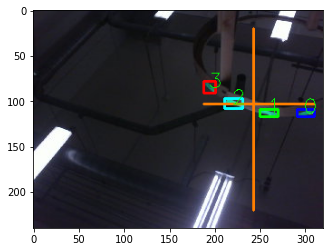

In [44]:
#h = [90, 150]  # change the allowed hues
contours = process(img_rgb)

In [45]:
rects = []
im_h, im_w, _ = img_rgb.shape 
for contour in filtered_contours:
    rect = cv2.boundingRect(contour)
    x, y, w, h = rect
    moments = cv2.moments(contour)  # moments 
    rects.append({'rect_x':x+w/2, 'rect_y':y+h/2, 'centroid_x':(moments["m10"] / moments["m00"]),
                 'centroid_y':moments["m01"] / moments["m00"],
                 'width':w, 'height':h,
                 'vertical':h/im_h, 'horizontal':w/im_w,
                 'image_percent':100 * w*h / (im_h * im_w)})

In [24]:
# display the list of dictionaries in a dataframe
df = pd.DataFrame(rects)
df.round(2)

,rect_x,rect_y,centroid_x,centroid_y,width,height,vertical,horizontal,image_percent
0,144.5,206.0,143.24,205.74,11,4,0.02,0.03,0.06
